<a href="https://colab.research.google.com/github/Asfilcnx3/Project2_LoadWine/blob/main/LoadWine_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the Wine Dataset to do a multinomial classification with a Dense Neural Network

In [1]:
# Import all the libraries to use
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline', 'target'],
      dtype='object')
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    fl

<Axes: xlabel='target'>

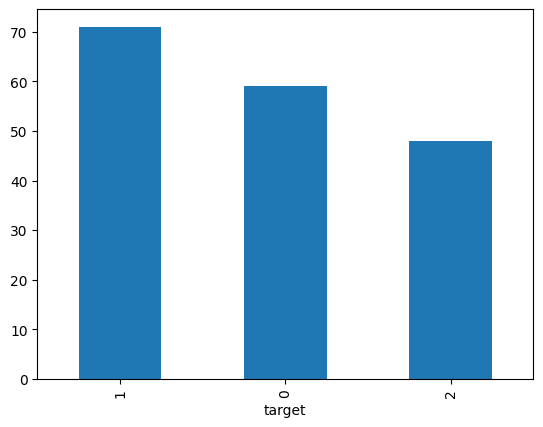

In [2]:
# Load all data and make a basic exploration
load_wine = load_wine()
df = pd.DataFrame(load_wine.data, columns=load_wine.feature_names)
df['target'] = load_wine.target
print(df.columns)
print("----" * 10)

print(df.info())
print("----" * 10)

print(df["target"].value_counts())
print("----" * 10)

df["target"].value_counts().plot(kind="bar")

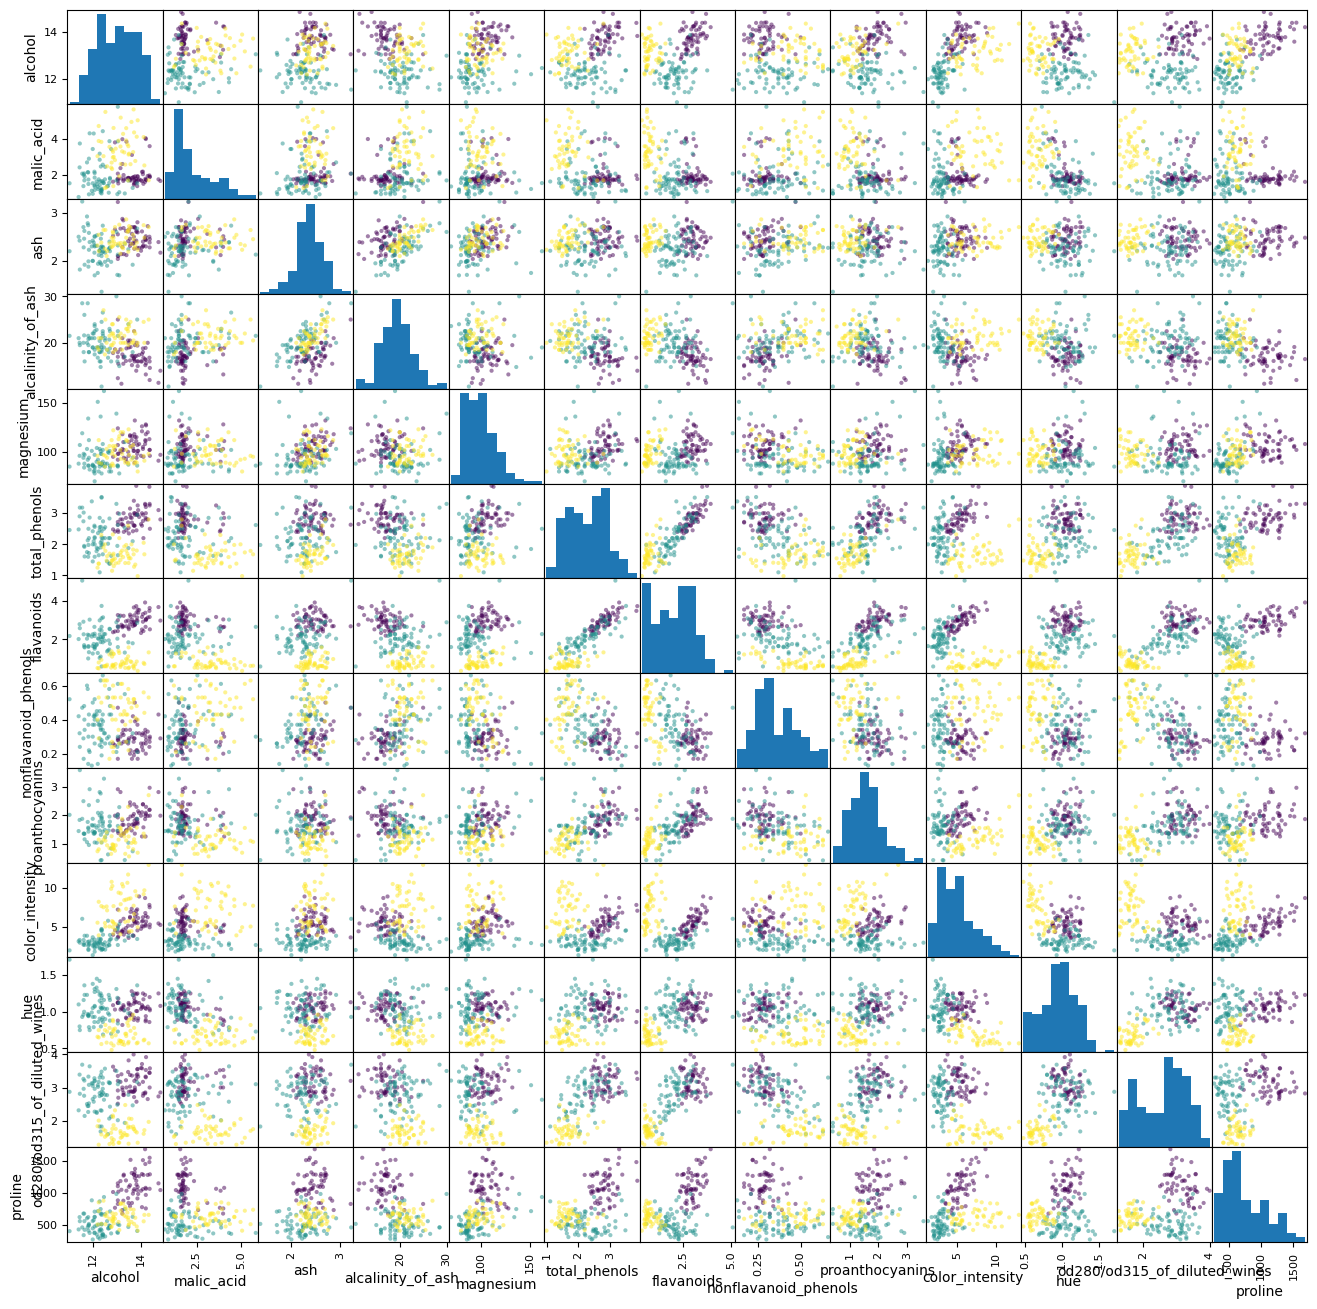

In [3]:
# Create "X" y "y"
X = df.drop(["target"], axis=1)
y = df["target"]

# A basic data visual exploration
pd.plotting.scatter_matrix(X, c=y, figsize=(16,16), ax=None)
plt.show()
# Theres a lot of relations between the data, that relations will help us to classify.

In [4]:
# Start with the data cleaning:
scaler = StandardScaler() # Scale Data
X_scaled = scaler.fit_transform(X)


# Do the train test split (no valid data)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    stratify=y, # stratify by "y"
    test_size=0.2,
    random_state=42
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Transform data to tensor to work with pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

(142, 13)
(36, 13)
(142,)
(36,)
torch.Size([142, 13])
torch.Size([142])
torch.Size([36, 13])
torch.Size([36])


## Creating the Simple Neural Network with this arquitecture:
`3 Dense layers with ReLU activation`


Epoch [10/80], Loss: 0.0963
Epoch [20/80], Loss: 0.0051
Epoch [30/80], Loss: 0.0009
Epoch [40/80], Loss: 0.0003
Epoch [50/80], Loss: 0.0002
Epoch [60/80], Loss: 0.0002
Epoch [70/80], Loss: 0.0001
Epoch [80/80], Loss: 0.0001
----------------------------------------
Accuracy: 97.2222%
----------------------------------------


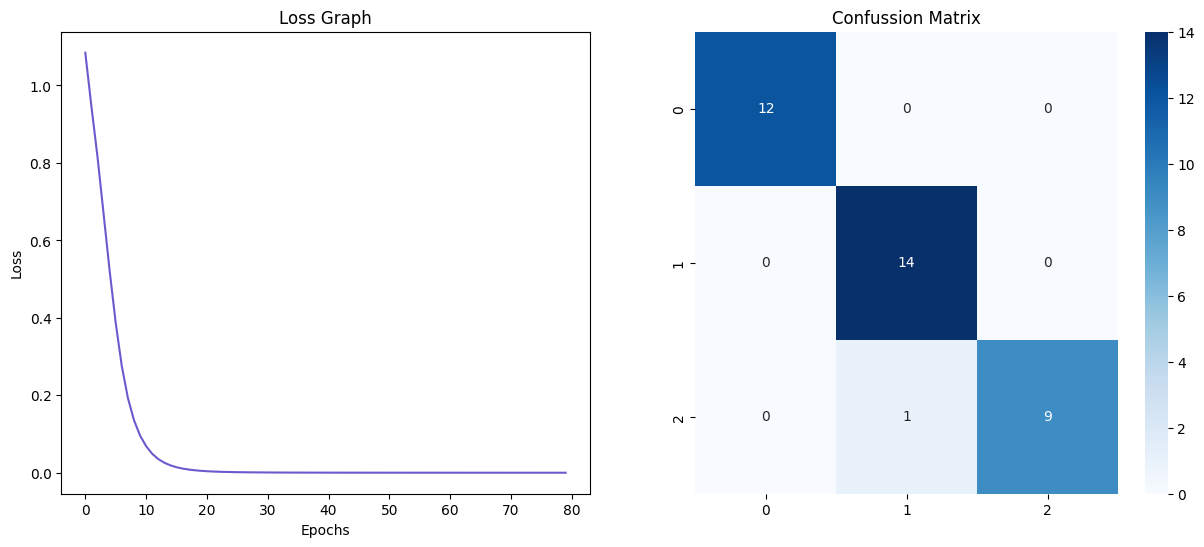

In [5]:
# Creamos la red
class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.fc1 = nn.Linear(13, 64) # 13 input features
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 3) # 3 outputs

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.out(x) # No activation at the end
model = SimpleRNN()

# Params
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.01)

# Create the training loop
epochs = 80
losses = []
for epoch in range(epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


# Evaluate Model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    acc = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
    print("----" * 10)
    print(f'Accuracy: {acc*100:.4f}%')
    print("----" * 10)


fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(losses, color="slateblue")
ax[0].set_title("Loss Graph")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

cm = confusion_matrix(y_test_tensor.numpy(), predicted.numpy())
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confussion Matrix")

plt.show()